In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import wi

In [176]:
# Data Loading
df = pd.read_csv('./Data/inverse_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2462 entries, 0 to 2461
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2462 non-null   object 
 1   Open    2462 non-null   int64  
 2   High    2462 non-null   int64  
 3   Low     2462 non-null   int64  
 4   Close   2462 non-null   int64  
 5   Volume  2462 non-null   int64  
 6   Change  2462 non-null   float64
dtypes: float64(1), int64(5), object(1)
memory usage: 134.8+ KB


In [177]:
# orginal data
original_close = df['Close'].values

# separate dates for future plotting
dates = pd.to_datetime(df['Date'])

# variables for training
cols = ['Open', 'High', 'Low', 'Close', 'Volume']

# new dataframe with only training data - 5 columns
df = df[cols].astype(float)

# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df)
stock_data_scaled = scaler.transform(df)

# split to train data and test data
n_train = int(0.9*stock_data_scaled.shape[0])
train_data_scaled = stock_data_scaled[0: n_train]
train_dates = dates[0: n_train]

test_data_scaled = stock_data_scaled[n_train:]
test_dates = dates[n_train:]

In [163]:
pred_days = 1
seq_len = 7
batch = 100

trainX = []
trainY = []
testX = []
testY = []

for i in range(seq_len, n_train-pred_days +1):
    trainX.append(train_data_scaled[i - seq_len:i, 0:train_data_scaled.shape[1]])
    trainY.append(train_data_scaled[i + pred_days - 1:i + pred_days, 0])

for i in range(seq_len, len(test_data_scaled)-pred_days +1):
    testX.append(test_data_scaled[i - seq_len:i, 0:test_data_scaled.shape[1]])
    testY.append(test_data_scaled[i + pred_days - 1:i + pred_days, 0])

trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)

print(f"trainX:{trainX.shape}, testX:{testX.shape}, trainY:{trainY.shape}, testY:{testY.shape}")

# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        batch_size=batch,
                        shuffle=True,  
                        drop_last=True)

trainX:(2208, 7, 5), testX:(240, 7, 5), trainY:(2208, 1), testY:(240, 1)


In [167]:
# Hyper Parameter
num_classes = 1 #number of output classes 

input_size = 5
hidden_size = 25
num_layers = 1

learning_rate = 0.0001
nb_epochs = 300

class LSTM(nn.Module):
    # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes 
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers 
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True)

        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer
        self.relu = nn.ReLU()

    def forward(self, x) :
        # Propagate input through LSTM
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
           
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # lstm with input, hidden, and internal state

        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output

        return out

In [165]:
def train_model(model, train_df, num_epochs = None, lr = None, verbose = 1, patience = 5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs
    
    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
            
            # H(x) 계산
            outputs = model.forward(x_train)
            # cost 계산
            loss = criterion(outputs, y_train)                 
            
            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss.item()/total_batch
               
        train_hist[epoch] = avg_cost        
        
        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
            
        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            
            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')
                
                break

    return model.eval(), train_hist

In [168]:
# 모델 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTM(num_classes, input_size, hidden_size, num_layers, seq_length).to(device)
trained_model, train_hist = train_model(model, dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 20, patience = 10)

Epoch: 0000 train loss : 0.8960
Epoch: 0020 train loss : 0.0209
Epoch: 0040 train loss : 0.0060
Epoch: 0060 train loss : 0.0046
Epoch: 0080 train loss : 0.0039
Epoch: 0100 train loss : 0.0035
Epoch: 0120 train loss : 0.0032
Epoch: 0140 train loss : 0.0029
Epoch: 0160 train loss : 0.0027
Epoch: 0180 train loss : 0.0024
Epoch: 0200 train loss : 0.0021
Epoch: 0220 train loss : 0.0019
Epoch: 0240 train loss : 0.0017
Epoch: 0260 train loss : 0.0016
Epoch: 0280 train loss : 0.0014

 Early Stopping


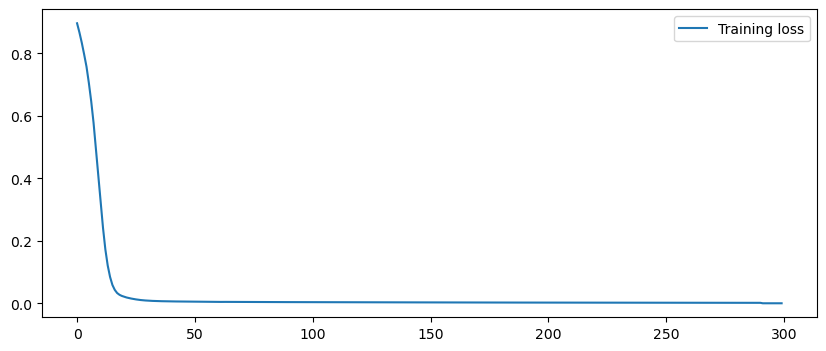

In [169]:
# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

In [102]:
test_set.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,-0.183701,-0.147365,-0.166477,-0.130659,-0.762946,0.011811
2020-01-03,-0.173119,-0.129791,-0.173557,-0.127130,-0.463626,0.000778
2020-01-06,-0.088463,-0.108701,-0.085062,-0.091848,-0.593702,0.007776
2020-01-07,-0.113155,-0.136820,-0.134619,-0.141244,-0.475082,-0.010802
2020-01-08,-0.106100,-0.105186,-0.109841,-0.109489,-0.113337,0.007020


/var/folders/82/yjz_v88n7jnb6641bk83qtvw0000gn/T/ipykernel_23261/501801010.py:15: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(test_dates[seq_len:], testY_original, color='blue', label='Actual Open Price')
/var/folders/82/yjz_v88n7jnb6641bk83qtvw0000gn/T/ipykernel_23261/501801010.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(test_dates[seq_len:], y_pred, color='red', linestyle='--', label='Predicted Open Price')


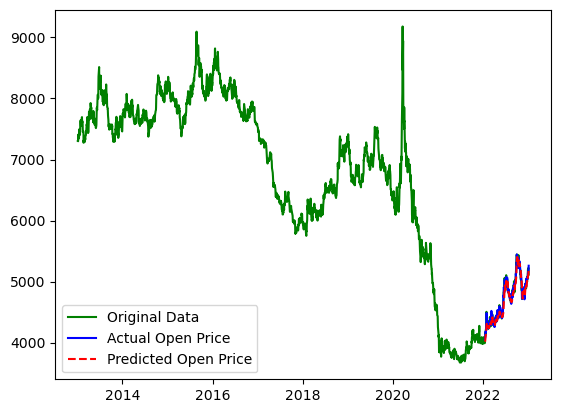

In [174]:
train_predict = trained_model(testX_tensor)
prediction = train_predict.data.numpy()
label_y = testY_tensor.data.numpy()

mean_values_pred = np.repeat(scaler.mean_[np.newaxis, :], prediction.shape[0], axis=0)
mean_values_pred[:, 0] = np.squeeze(prediction)
y_pred = scaler.inverse_transform(mean_values_pred)[:, 0]

mean_values_testY = np.repeat(scaler.mean_[np.newaxis, :], testY.shape[0], axis=0)
mean_values_testY[:, 0] = np.squeeze(testY)
testY_original = scaler.inverse_transform(mean_values_testY)[:, 0]

original_close = df['Close'].values
plt.plot(dates, original_close, color='green', label = 'Original Data')
plt.plot(test_dates[seq_len:], testY_original, color='blue', label='Actual Open Price')
plt.plot(test_dates[seq_len:], y_pred, color='red', linestyle='--', label='Predicted Open Price')
plt.legend()
plt.show()